In [3]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [107]:
%%time
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['CO2','CO2_OCN','theta','U','PS','Z3']

ds = cesm.open_casedata(case,'atm','cam.h0',varlist)

ds = ds.sel(time=slice('2016-01-15','2016-02-29'))
ds = ds.sel(lon=-80.+360.,lat=slice(-90,-30))
ds = cesm.convert_dataset(ds,case)

print('ds size {:0.2f}GB\n'.format(ds.nbytes / 1e9))
ds.info()

ds size 0.00GB

xarray.Dataset {
dimensions:
	ilev = 57 ;
	lat = 64 ;
	lev = 56 ;
	nbnd = 2 ;
	slat = 191 ;
	slon = 288 ;
	time = 46 ;

variables:
	float32 CO2(time, lev, lat) ;
		CO2:units = ppmv ;
		CO2:long_name = CO2 ;
	float64 P0() ;
		P0:long_name = reference pressure ;
		P0:units = Pa ;
	float64 ch4vmr(time) ;
		ch4vmr:long_name = ch4 volume mixing ratio ;
	float64 co2vmr(time) ;
		co2vmr:long_name = co2 volume mixing ratio ;
	float64 f11vmr(time) ;
		f11vmr:long_name = f11 volume mixing ratio ;
	float64 f12vmr(time) ;
		f12vmr:long_name = f12 volume mixing ratio ;
	float64 gw(lat) ;
		gw:long_name = gauss weights ;
	float64 hyai(ilev) ;
		hyai:long_name = hybrid A coefficient at layer interfaces ;
	float64 hyam(lev) ;
		hyam:long_name = hybrid A coefficient at layer midpoints ;
	float64 hybi(ilev) ;
		hybi:long_name = hybrid B coefficient at layer interfaces ;
	float64 hybm(lev) ;
		hybm:long_name = hybrid B coefficient at layer midpoints ;
	float64 ilev(ilev) ;
		ilev:long_nam

In [57]:
reload(cam)
dsp = cam.pres_hybrid(ds)
dsp = cam.remap_vertical_coord(dsp.Pm,*[dsp[v] for v in varlist])
dsp

interpolating CO2
interpolating CO2_OCN
interpolating theta
interpolating U


<xarray.Dataset>
Dimensions:  (lat: 64, plev: 59, time: 46)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * time     (time) datetime64[ns] 2016-01-15 2016-01-16 2016-01-17 ...
    lon      float64 280.0
  * plev     (plev) float64 50.0 100.0 150.0 200.0 250.0 290.0 330.0 370.0 ...
Data variables:
    theta    (time, plev, lat) float64 552.4 552.0 551.9 551.5 551.2 550.9 ...
    CO2      (time, plev, lat) float64 387.7 387.8 387.8 387.8 387.6 387.5 ...
    U        (time, plev, lat) float64 6.303 5.912 5.621 5.296 5.004 4.694 ...
    CO2_OCN  (time, plev, lat) float64 -4.134 -4.155 -4.159 -4.148 -4.118 ...
    PS       (time, lat) float32 689.059 694.826 706.943 748.679 796.919 ...

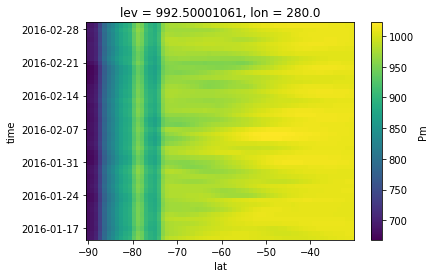

In [56]:
dsp.Pm.isel(lev=-1).plot()

Text(0,0.5,u'Pressure [hPa]')

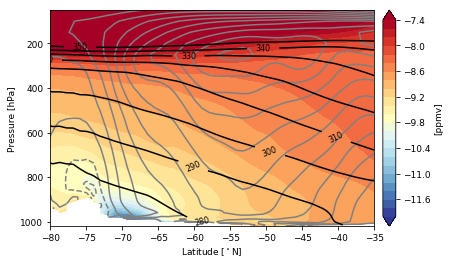

In [116]:
import plot_tools
v = 'CO2_OCN'

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.1,0.1,0.75,0.75])

#ax.minorticks_on()
#ax.tick_params(which='major',direction='out',width=1,  length=6)
#ax.tick_params(which='minor',direction='out',width=0.5,length=4)

cf = ax.contourf(dsp.lat, dsp.plev, dsp[v].mean(dim='time'),
                 levels=np.arange(-12,-7.2,0.2),
                 cmap = 'RdYlBu_r',
                 extend='both')

cs = ax.contour(dsp.lat, dsp.plev, dsp.U.mean(dim='time'),
                 levels=np.arange(-40,42.5,2.5),
                 colors = 'gray',
                 linewi = 0.5)

cs = ax.contour(dsp.lat, dsp.plev, dsp.theta.mean(dim='time'),
                 levels = np.arange(280.,360.,10),
                 colors = 'black',
                 linewi = 0.1)

cs.levels = [plot_tools.contour_label_format(val) for val in cs.levels]
fmt = '%r'
lb = plt.clabel(cs, fontsize=8,
                inline = True,
                fmt=fmt)
    
cbax = fig.add_axes([0.87,0.1,0.03,0.75])
cb = plt.colorbar(cf,cax=cbax)
cb.set_label('['+dsp[v].attrs['units']+']')

ax.set_xlim([-80.,-35.])
ax.set_ylim([dsp.plev[-1],dsp.plev[0]])

ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('Pressure [hPa]')

In [112]:
geopotential_height_levels = xr.DataArray(
        np.array([ 42482.4296875,40789.765625,39157.46875,
                   37586.35546875,36074.7578125,34620.71875,
                   33221.05078125,31872.421875,30571.47265625,
                   29308.29492188,28075.45507812,26870.96875,
                   25694.5390625,24545.7109375,23423.09570312,
                   22326.65625,21252.5234375,20197.5078125,
                   19162.2578125,18146.8984375,17149.96484375,
                   16160.68554688,15167.20898438,14164.18066406,
                   13147.97851562,12116.08984375,11066.44824219,
                   9995.7109375,8912.61816406,8007.54882812,
                   7296.19238281,6637.14892578,6022.51513672,
                   5446.35351562,4903.87304688,4391.23974609,
                   3905.2668457,3443.27319336,3074.66967773,
                   2790.08691406,2513.83837891,2245.44848633,
                   1984.4967041,1755.61950684,1581.37988281,
                   1434.59033203,1290.03381348,1147.62548828,
                   1007.2913208,868.96289062,732.5602417,
                   598.00524902,465.22851562,334.16360474,
                   204.7640686,77.2164535]),
        dims=('zlev'),
        attrs={'long_name':'Geopotential height (above sea level)',
               'units':'m'})

dsh = cam.remap_vertical_coord(ds.Z3,*[ds[v] for v in varlist],new_levels=geopotential_height_levels)
dsh.zlev.values = dsh.zlev.values * 1e-3
dsh

interpolating CO2
interpolating CO2_OCN
interpolating theta
interpolating U
interpolating Z3


<xarray.Dataset>
Dimensions:  (lat: 64, time: 46, zlev: 56)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * time     (time) datetime64[ns] 2016-01-15 2016-01-16 2016-01-17 ...
    lon      float64 280.0
  * zlev     (zlev) float64 42.48 40.79 39.16 37.59 36.07 34.62 33.22 31.87 ...
Data variables:
    PS       (time, lat) float32 ...
    CO2      (time, zlev, lat) float64 381.7 381.7 381.7 381.6 381.6 381.6 ...
    U        (time, zlev, lat) float64 0.4009 -0.4731 -1.243 -2.078 -2.944 ...
    CO2_OCN  (time, zlev, lat) float64 -2.343 -2.343 -2.342 -2.338 -2.331 ...
    theta    (time, zlev, lat) float64 1.528e+03 1.528e+03 1.529e+03 ...
    Z3       (time, zlev, lat) float64 4.249e+04 4.249e+04 4.249e+04 ...

Text(0,0.5,u'Altitude [km]')

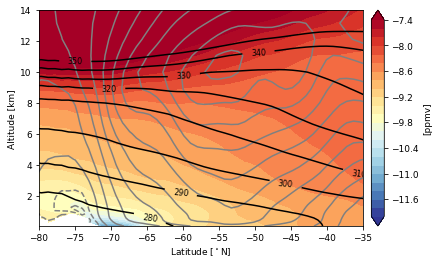

In [115]:
v = 'CO2_OCN'

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.1,0.1,0.75,0.75])

#ax.minorticks_on()
#ax.tick_params(which='major',direction='out',width=1,  length=6)
#ax.tick_params(which='minor',direction='out',width=0.5,length=4)

cf = ax.contourf(dsh.lat, dsh.zlev, dsh[v].mean(dim='time'),
                 levels=np.arange(-12,-7.2,0.2),
                 cmap = 'RdYlBu_r',
                 extend='both')

cs = ax.contour(dsh.lat, dsh.zlev, dsh.U.mean(dim='time'),
                 levels=np.arange(-40,42.5,2.5),
                 colors = 'gray',
                 linewi = 0.5)

cs = ax.contour(dsh.lat, dsh.zlev, dsh.theta.mean(dim='time'),
                 levels = np.arange(280.,360.,10),
                 colors = 'black',
                 linewi = 0.1)

cs.levels = [plot_tools.contour_label_format(val) for val in cs.levels]
fmt = '%r'
lb = plt.clabel(cs, fontsize=8,
                inline = True,
                fmt=fmt)
    
cbax = fig.add_axes([0.87,0.1,0.03,0.75])
cb = plt.colorbar(cf,cax=cbax)
cb.set_label('['+dsh[v].attrs['units']+']')

ax.set_xlim([-80.,-35.])
ax.set_ylim([dsh.zlev[-1],14.])

ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('Altitude [km]')